# KMEANS

###Content
- Đọc file
- Data processing
- Giảm chiều bằng PCA
- Đánh giá việc phân cụm - Phân cụm dựa trên PCA
- Giảm chiều bằng T-SNE
- Phân cụm dựa trên T-SNE

1. Import thư viện 

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,make_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from sklearn.metrics import silhouette_score



2. Đọc File

In [2]:
data = pd.read_csv("./traindatanorm.csv")
print("Raw data shape: ", data.shape)


Raw data shape:  (7809, 5)


3. Gộp các cột

In [3]:
data['combined_text'] = data['Course_Title'] + ' ' + data['Description'] + ' ' + data['Course_Content'] + ' ' + data['Lecturers_name']

4. TF-IDF

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=2000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_text'])
tfidf_matrix.shape

(7809, 2000)

5. Giảm chiều dữ liệu bằng PCA

In [5]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
 
reduced_tfidf.shape

(7809, 2)

6. Đánh giá - Lựa chọn K dựa vào Elbow

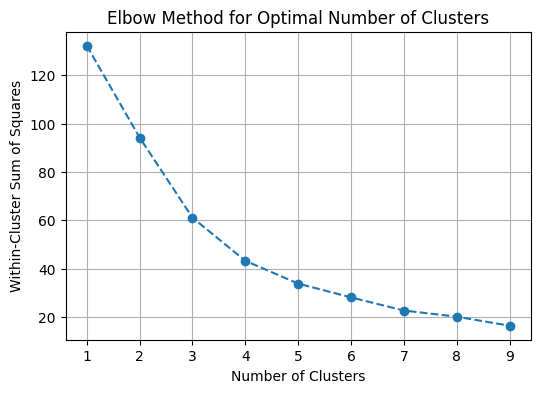

In [63]:
wcss = []  # within-cluster sum of squares
cluster_range = range(1, 10)  # test up to 10 clusters
 
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_tfidf)
    wcss.append(kmeans.inertia_)
 
# Plot the Elbow method
plt.figure(figsize=(6, 4))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

7. Đánh giá - Lựa chọn K dựa vào silhouette_scores

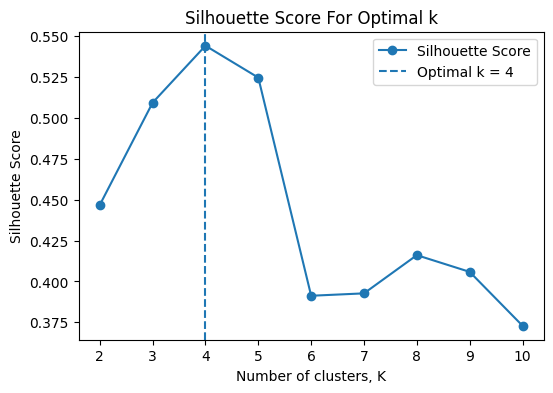

In [64]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming reduced_tfidf is your dataset
silhouette_scores = []

# Calculate silhouette scores for k values from 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_tfidf)
    score = silhouette_score(reduced_tfidf, kmeans.labels_)
    silhouette_scores.append(score)

# Determine the k with the highest silhouette score
optimal_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]

# Plot the silhouette scores
plt.figure(figsize=(6, 4))
line, = plt.plot(range(2, 11), silhouette_scores, '-o', label='Silhouette Score')
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.axvline(optimal_k, color=line.get_color(), linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

=> Phương pháp Silhouette: Tại vị trí K = 4, độ đo bóng (Silhouette score) cao nhất nên được chọn làm số lượng cụm tối ưu 

8. Biểu đồ phân cụm

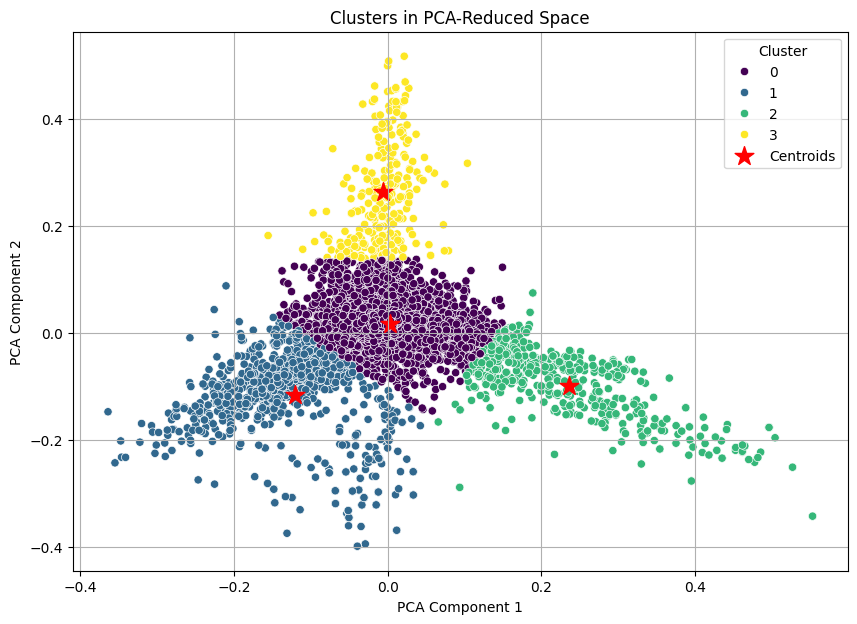

In [12]:
# Perform KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(reduced_tfidf)
data['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_tfidf[:, 0], y=reduced_tfidf[:, 1], hue=clusters, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='*', label='Centroids')
plt.title('Clusters in PCA-Reduced Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [15]:
cluster_counts = data['cluster'].value_counts().sort_index()

for cluster, count in cluster_counts.items():
    print(f'Cụm {cluster}: {count}')

Cụm 0: 5829
Cụm 1: 1149
Cụm 2: 507
Cụm 3: 324


9. Biểu đồ phân cụm trên mô hình 3D

In [66]:
import plotly.graph_objs as go
import plotly.express as px

# Assume 'data' is your DataFrame with 'cluster' column and 'reduced_tfidf' is your PCA-reduced data

# Convert cluster labels to strings
data['cluster'] = data['cluster'].astype(str)

# Create the 3D scatter plot
fig = px.scatter_3d(x=reduced_tfidf[:, 0], y=reduced_tfidf[:, 1], z=np.zeros(len(reduced_tfidf)),
                    color=data['cluster'], labels={'x': 'x', 'y': 'y', 'z': 'z'},
                    title='Clusters in PCA-Reduced Space (3D)', color_discrete_sequence=px.colors.qualitative.Pastel)

# Add centroids to the plot using plotly graph objects
fig.add_trace(go.Scatter3d(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], z=np.zeros(len(kmeans.cluster_centers_)),
                           mode='markers', marker=dict(color='red', size=10, symbol='cross'), name='Centroids'))

# Update layout for better visualization
fig.update_layout(scene=dict(xaxis_title='x',
                             yaxis_title='y',
                             zaxis_title='z'),
                  legend=dict(title='Cluster'))

# Show the plot
fig.show()


10. Biểu đồ Phân bố Danh mục Chính trong các Cụm

In [9]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


k = 4

# Create subplots: 2 rows and 2 columns for 4 clusters with increased vertical spacing
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Cluster {i}' for i in range(k)], vertical_spacing=0.2)

# Dictionary to map cluster number to subplot position
subplot_mapping = {
    0: (1, 1),
    1: (1, 2),
    2: (2, 1),
    3: (2, 2)
}

for cluster_num in range(k):
    cluster_data = data[data['cluster'] == cluster_num]
    category_counts = cluster_data['Main_Category'].value_counts().reset_index()
    category_counts.columns = ['Main_Category', 'Frequency']
    
    # Add bar plot to the corresponding subplot
    row, col = subplot_mapping[cluster_num]
    fig.add_trace(
        go.Bar(
            x=category_counts['Main_Category'],
            y=category_counts['Frequency'],
            text=category_counts['Frequency'],  
            textposition='outside', 
            name=f'Cluster {cluster_num}'
        ),
        row=row, col=col
    )

# Update layout to add titles and set consistent x-axis label angles
fig.update_layout(
    title_text='Distribution of Main Categories in Clusters',
    showlegend=False,
    height=1000
)

for i in range(1, 3):
    for j in range(1, 3):
        fig.update_xaxes(tickangle=-45, row=i, col=j)

# Show the combined plot
fig.show()

11. Word Cloud tương ứng với 4 cụm

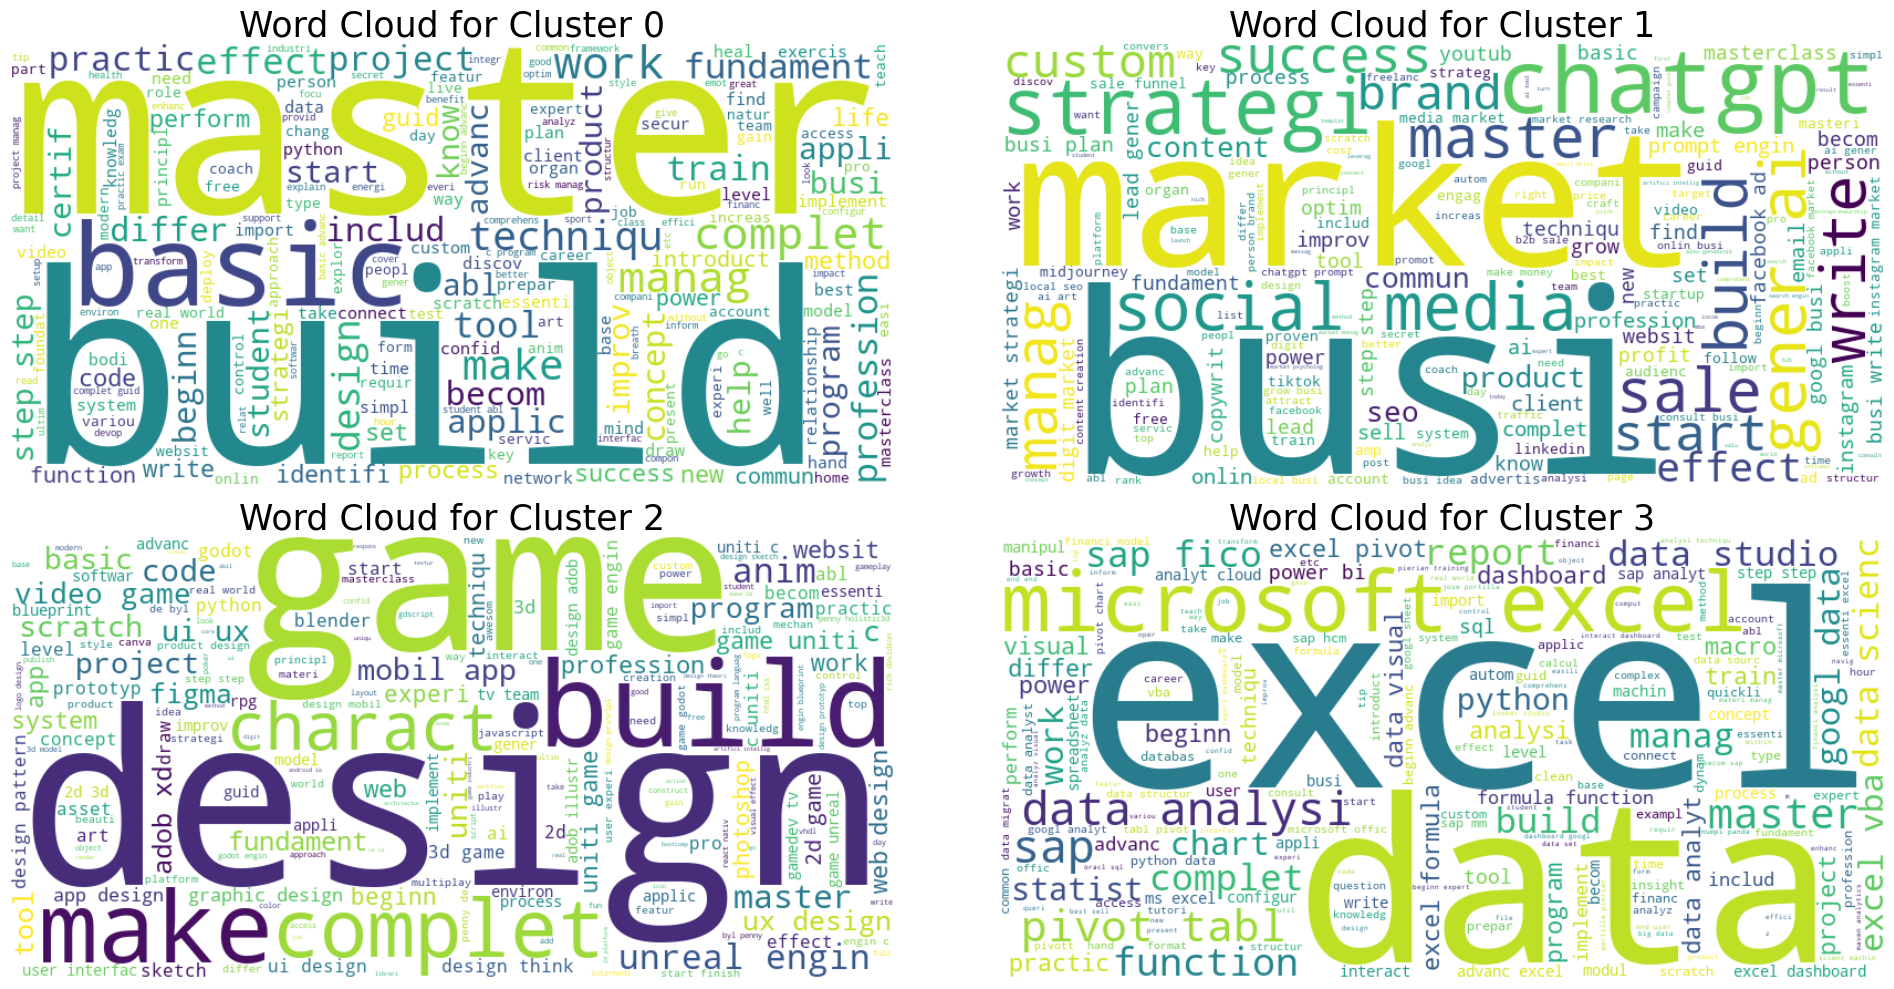

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary to hold combined texts for each cluster
cluster_texts = {cluster: [] for cluster in data['cluster'].unique()}

# Populate the dictionary with texts for each cluster
for cluster, text in zip(data['cluster'], data['combined_text']):
    cluster_texts[cluster].append(text)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot word clouds for each cluster
for cluster_num, texts in cluster_texts.items():
    combined_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Determine the subplot position
    row = cluster_num // 2
    col = cluster_num % 2
    
    # Plot the word cloud in the corresponding subplot
    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].set_title(f'Word Cloud for Cluster {cluster_num}', fontsize=25)
    axs[row, col].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Tính Silhouette score
silhouette_avg = silhouette_score(reduced_tfidf, clusters)
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Tính Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(reduced_tfidf, clusters)
print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

# Tính Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(reduced_tfidf, clusters)
print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')

Silhouette Score: 0.5490
Davies-Bouldin Index: 0.6628
Calinski-Harabasz Index: 5421.0060


12. Giảm chiều bằng T-SNE

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())


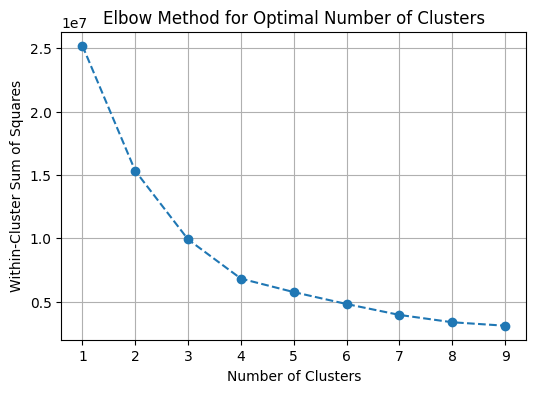

In [12]:
wcss_tsne = []  # within-cluster sum of squares
cluster_range_tsne = range(1, 10)  # test up to 10 clusters
 
for k in cluster_range_tsne:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_results)
    wcss_tsne.append(kmeans.inertia_)
 
# Plot the Elbow method
plt.figure(figsize=(6, 4))
plt.plot(cluster_range_tsne, wcss_tsne, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

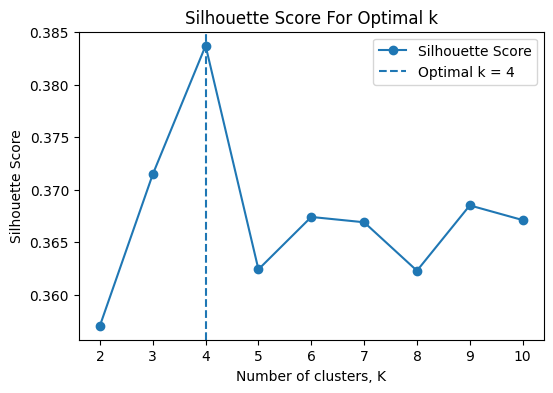

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming reduced_tfidf is your dataset
silhouette_scores = []

# Calculate silhouette scores for k values from 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne_results)
    score = silhouette_score(tsne_results, kmeans.labels_)
    silhouette_scores.append(score)

# Determine the k with the highest silhouette score
optimal_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]

# Plot the silhouette scores
plt.figure(figsize=(6, 4))
line, = plt.plot(range(2, 11), silhouette_scores, '-o', label='Silhouette Score')
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.axvline(optimal_k, color=line.get_color(), linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

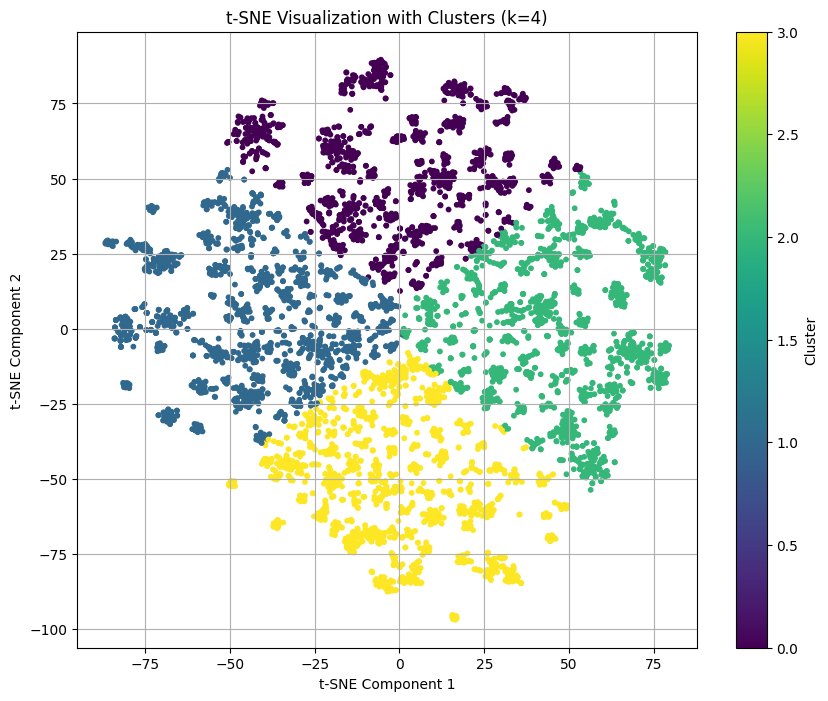

In [9]:
# Áp dụng K-means trên dữ liệu đã giảm chiều bằng t-SNE
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(tsne_results)

# Vẽ biểu đồ t-SNE với phân cụm được đánh dấu bằng màu sắc
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', marker='o', s=10)
plt.title('t-SNE Visualization with Clusters (k=4)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette_avg_tsne = silhouette_score(tsne_results, clusters)
print(f'Silhouette Score: {silhouette_avg_tsne:.4f}')

# Tính Davies-Bouldin Index
davies_bouldin_tsne = davies_bouldin_score(tsne_results, clusters)
print(f'Davies-Bouldin Index: {davies_bouldin_tsne:.4f}')

# Tính Calinski-Harabasz Index
calinski_harabasz_tsne = calinski_harabasz_score(tsne_results, clusters)
print(f'Calinski-Harabasz Index: {calinski_harabasz_tsne:.4f}')

Silhouette Score: 0.3827
Davies-Bouldin Index: 0.8306
Calinski-Harabasz Index: 6993.0237


In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

data['cluster-tsne'] = clusters

k = 4 

# Create subplots: 2 rows and 2 columns for 4 clusters with increased vertical spacing
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Cluster {i}' for i in range(k)], vertical_spacing=0.2)

# Dictionary to map cluster number to subplot position
subplot_mapping = {
    0: (1, 1),
    1: (1, 2),
    2: (2, 1),
    3: (2, 2)
}

for cluster_num in range(k):
    cluster_data = data[data['cluster-tsne'] == cluster_num]
    category_counts = cluster_data['Main_Category'].value_counts().reset_index()
    category_counts.columns = ['Main_Category', 'Frequency']
    
    # Add bar plot to the corresponding subplot
    row, col = subplot_mapping[cluster_num]
    fig.add_trace(
        go.Bar(
            x=category_counts['Main_Category'],
            y=category_counts['Frequency'],
            text=category_counts['Frequency'],  
            textposition='outside', 
            name=f'Cluster {cluster_num}'
        ),
        row=row, col=col
    )

# Update layout to add titles and set consistent x-axis label angles
fig.update_layout(
    title_text='Phân bố Danh mục Chính trong các Cụm',
    showlegend=False,
    height=1000  
)

for i in range(1, 3):
    for j in range(1, 3):
        fig.update_xaxes(tickangle=-45, row=i, col=j)

# Show the combined plot
fig.show()


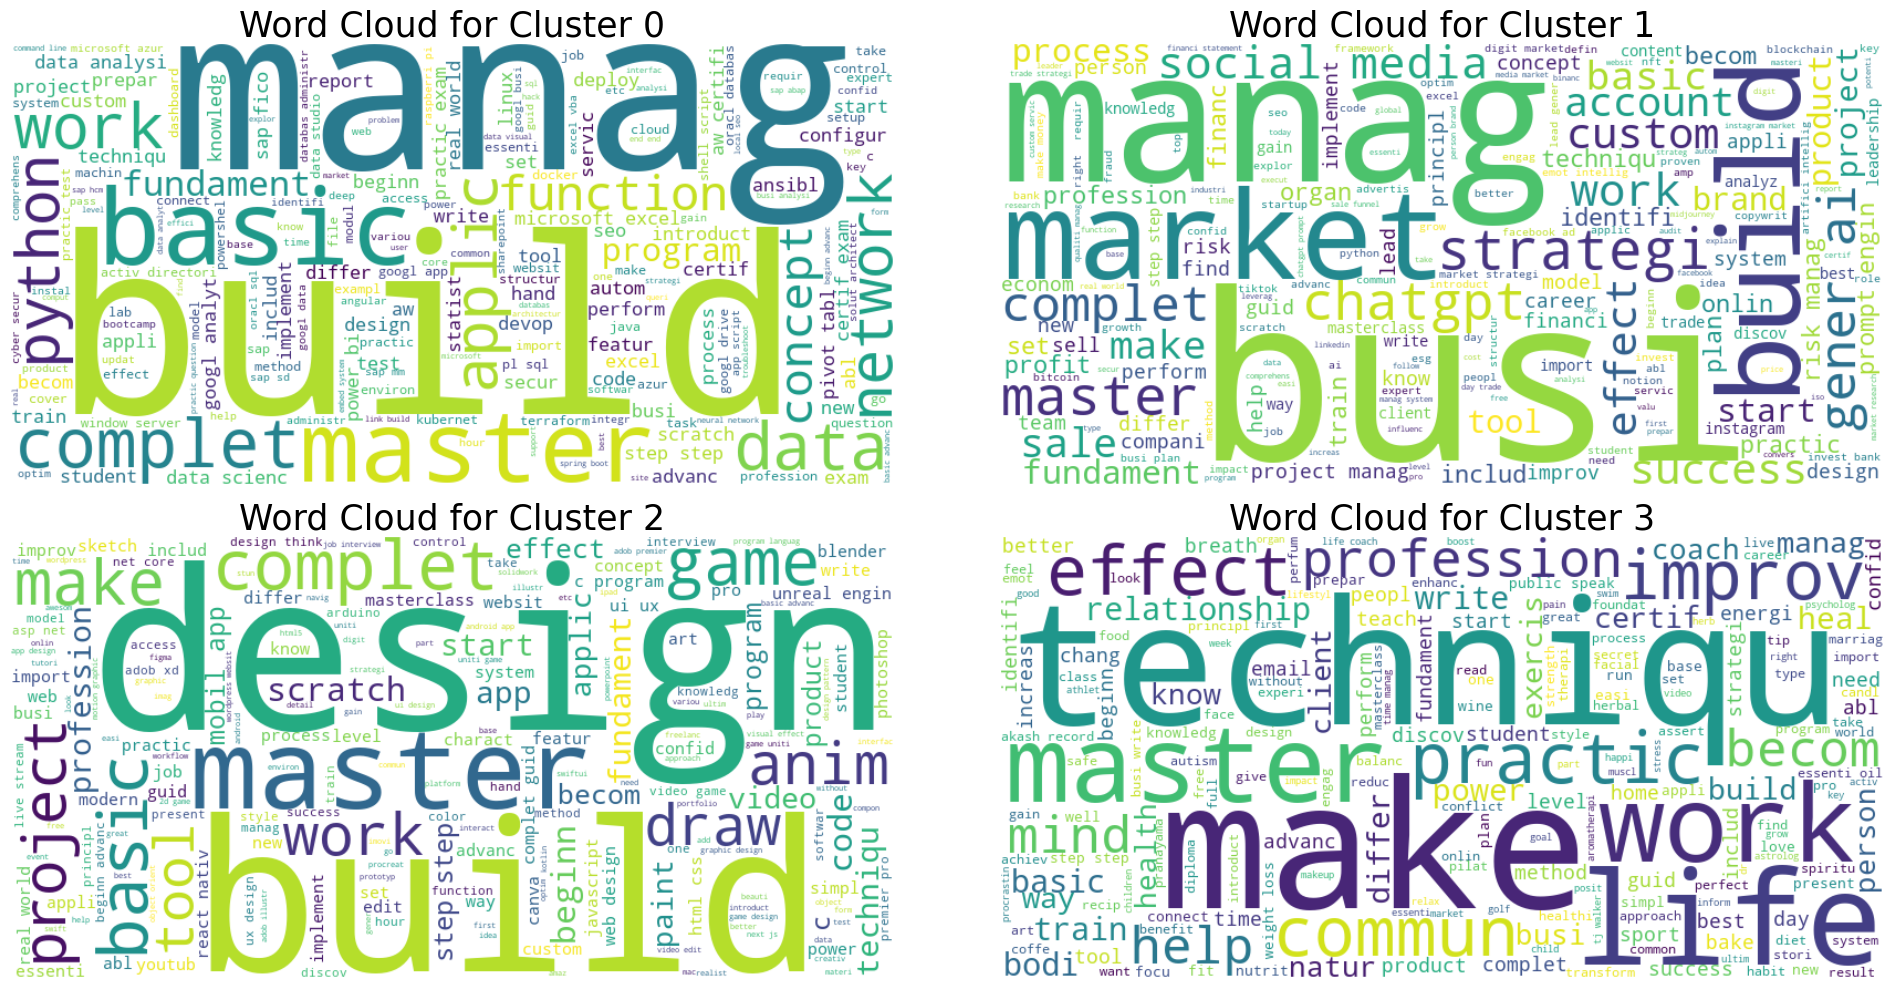

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming data['combined_text'] contains the combined text for each data point
cluster_texts = {i: [] for i in range(4)}
for i, text in zip(data['cluster-tsne'], data['combined_text']):
    cluster_texts[i].append(text)
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot word clouds for each cluster
for cluster_num, texts in cluster_texts.items():
    combined_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Determine the subplot position
    row = cluster_num // 2
    col = cluster_num % 2
    
    # Plot the word cloud in the corresponding subplot
    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].set_title(f'Word Cloud for Cluster {cluster_num}', fontsize=25)
    axs[row, col].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
